<a href="https://colab.research.google.com/github/vishusakhare/project/blob/main/cat_dog_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
100% 544M/545M [00:25<00:00, 22.9MB/s]
100% 545M/545M [00:25<00:00, 22.1MB/s]


In [3]:

import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras import regularizers
import shutil
import os

In [5]:
df=pd.read_csv('/content/cat_dog.csv')

In [6]:
df.head()

image  labels
0  dog.11289.jpg       1
1  cat.10836.jpg       0
2   cat.7970.jpg       0
3   cat.2212.jpg       0
4   dog.2653.jpg       1

In [7]:
df.isnull().sum()

image     0
labels    0
dtype: int64

In [8]:
df["image_path"] = df["image"].apply(lambda x: os.path.join("/content/cat_dog", x))
df = df[df["image_path"].apply(os.path.exists)]

In [9]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df["labels"], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["labels"], random_state=42)


In [10]:
image_size = (128, 128)
batch_size = 32

Data Augmentation

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [12]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0
    return img, label


In [13]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["image_path"].values, train_data["labels"].values))
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data["image_path"].values, val_data["labels"].values))
val_dataset = val_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data["image_path"].values, test_data["labels"].values))
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)




In [14]:
# Build a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


In [18]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.6402 - loss: 4.3106 - val_accuracy: 0.6687 - val_loss: 3.2955 - learning_rate: 1.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.7631 - loss: 2.9516 - val_accuracy: 0.7630 - val_loss: 2.3448 - learning_rate: 1.0000e-04
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.8032 - loss: 2.1327 - val_accuracy: 0.7885 - val_loss: 1.7800 - learning_rate: 1.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.8242 - loss: 1.6272 - val_accuracy: 0.8005 - val_loss: 1.4472 - learning_rate: 1.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.8469 - loss: 1.3182 - val_accuracy: 0.7855 - val_loss: 1.2993 - learning_rate: 1.0000e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.8634 - loss: 1.1217 - val_accuracy: 0.8117 - val_loss: 1.1684 - learning_rate: 1.0000e-04
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/ste

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,916,101 (37.83 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6,610,436 (25.22 MB)

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8846 - loss: 0.6243
Test Accuracy: 0.89, Test Loss: 0.59


In [29]:
sample_dataset = test_dataset.unbatch().take(100)

In [30]:
# Prepare lists to store images, true labels, and predictions
images, true_labels, predictions = [], [], []

In [31]:
# Collect the images, true labels, and predictions
for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

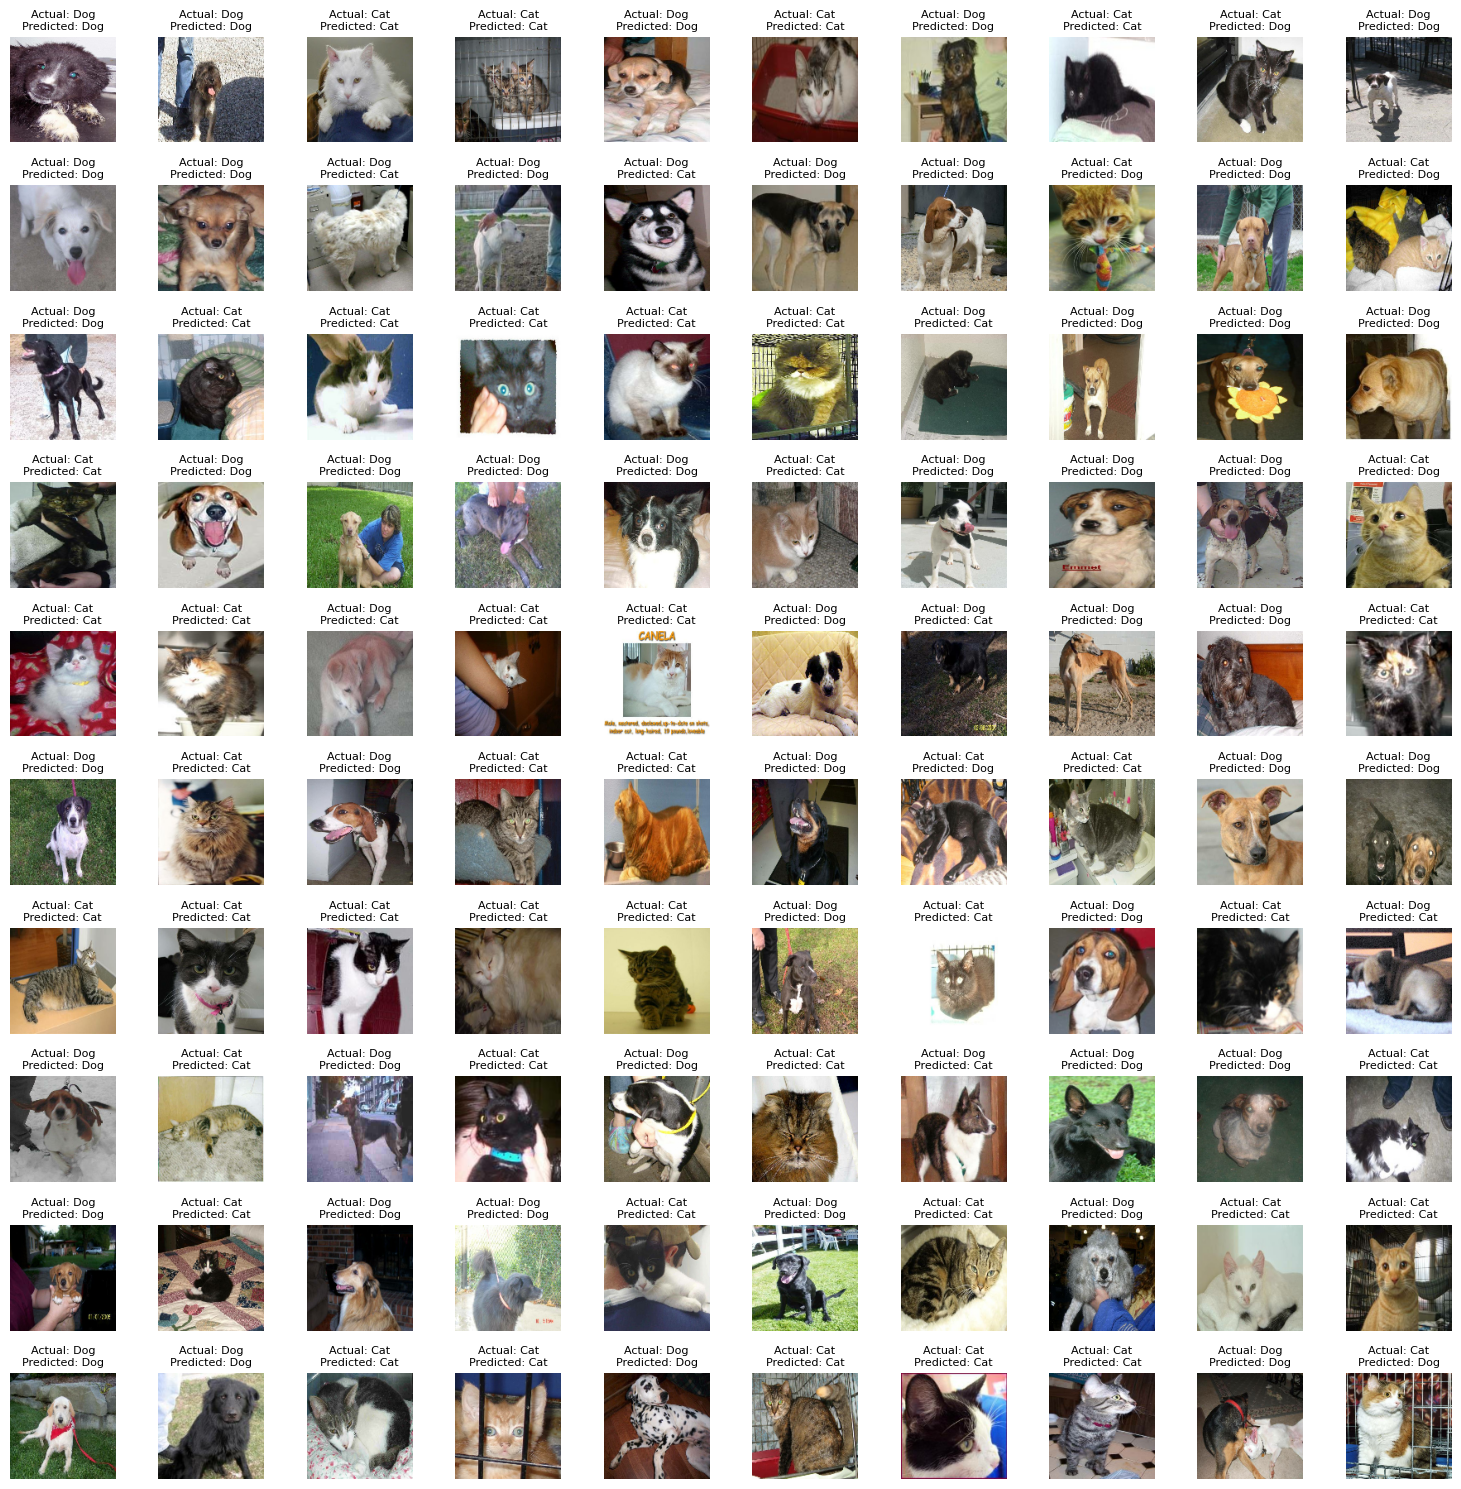

In [33]:
# Plot the 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')

    true_label = "Dog" if true_labels[i] == 1 else "Cat"
    predicted_label = "Dog" if predictions[i] > 0.5 else "Cat"
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()

In [35]:
# Use MobileNetV2 for transfer learning
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [36]:
model1 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

In [37]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [38]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [40]:
# Train the model
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.9651 - loss: 1.6780 - val_accuracy: 0.9668 - val_loss: 0.8687 - learning_rate: 1.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.9680 - loss: 0.7344 - val_accuracy: 0.9615 - val_loss: 0.4821 - learning_rate: 1.0000e-04
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.9707 - loss: 0.4134 - val_accuracy: 0.9678 - val_loss: 0.3046 - learning_rate: 1.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9727 - loss: 0.2779 - val_accuracy: 0.9690 - val_loss: 0.2424 - learning_rate: 1.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9675 - loss: 0.2324 - val_accuracy: 0.9690 - val_loss: 0.2226 - learning_rate: 1.0000e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9672 - loss: 0.2117 - val_accuracy: 0.9668 - val_loss: 0.1989 - learning_rate: 1.0000e-04
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/ste

In [41]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,621,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,123,077 (38.62 MB)

 Trainable params: 2,621,697 (10.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 5,243,396 (20.00 MB)

In [43]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model1.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9708 - loss: 0.1239
Test Accuracy: 97.24%, Test Loss: 0.1200


In [53]:
# Plot training and validation curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

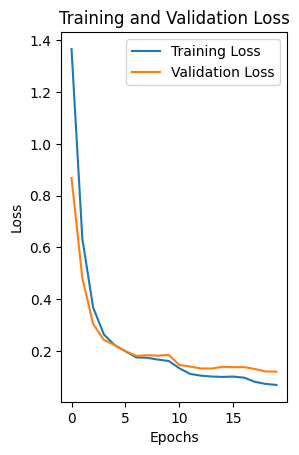

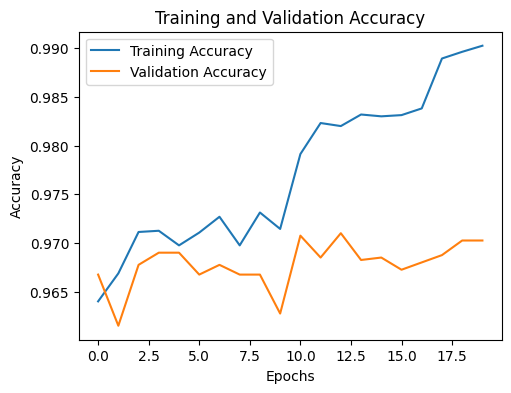

In [55]:
  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')

  plt.show()
  plot_learning_curves(history)

In [57]:
# Sample 100 images from the test dataset
sample_dataset = test_dataset.unbatch().take(100)

# Prepare lists to store images, true labels, and predictions
images, true_labels, predictions = [], [], []

# Collect the images, true labels, and predictions
for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model1.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

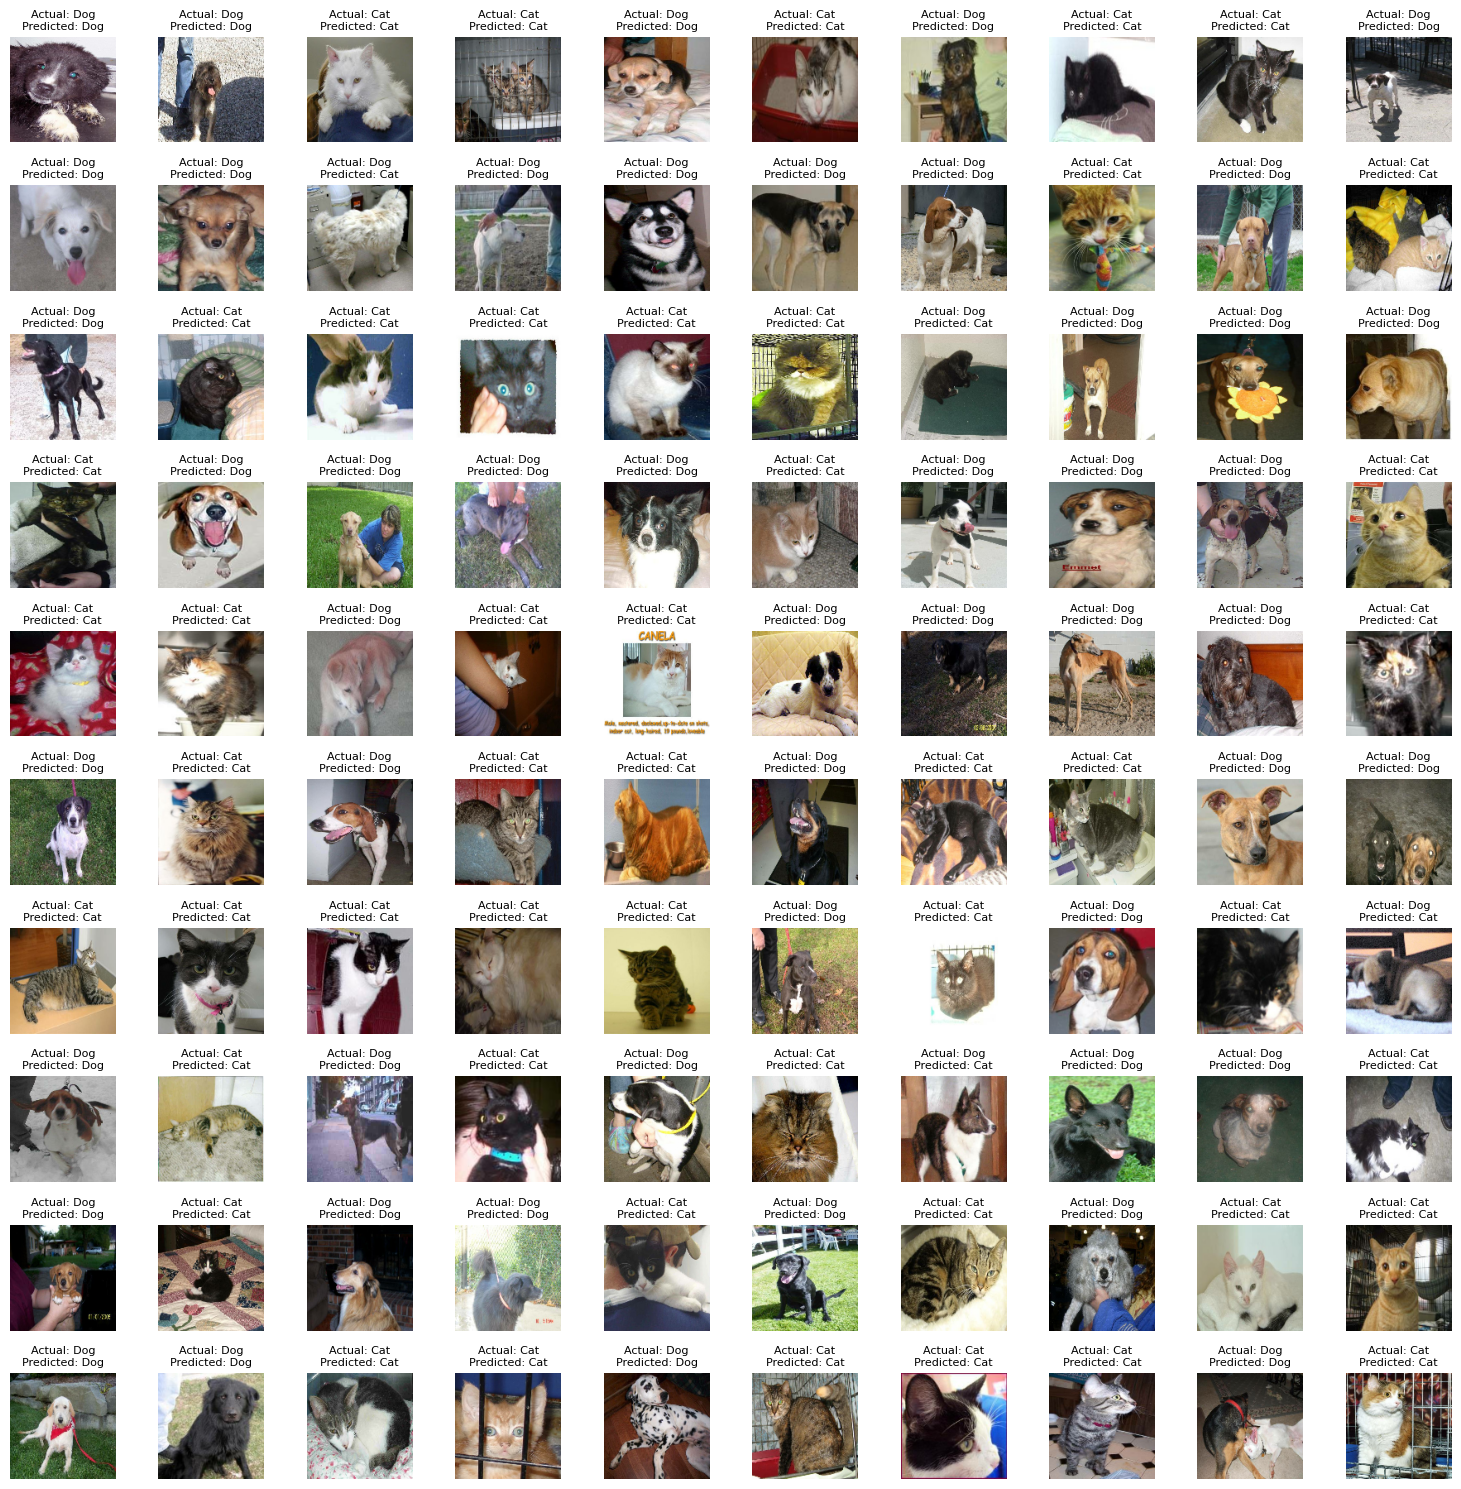

In [59]:
# Plot the 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')

    true_label = "Dog" if true_labels[i] == 1 else "Cat"
    predicted_label = "Dog" if predictions[i] > 0.5 else "Cat"
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()

In [60]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_single_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0
    return tf.expand_dims(img, axis=0)

def predict_and_display(image_path, model):
    processed_img = preprocess_single_image(image_path)

    prediction = model.predict(processed_img)[0][0]
    predicted_label = "Dog" if prediction > 0.5 else "Cat"

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


In [61]:
image_paths = [
    "/content/cat1.jpg",
    "/content/cat2.jpg",
    "/content/dog1.jpg",
    "/content/dog2.jpg"

]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


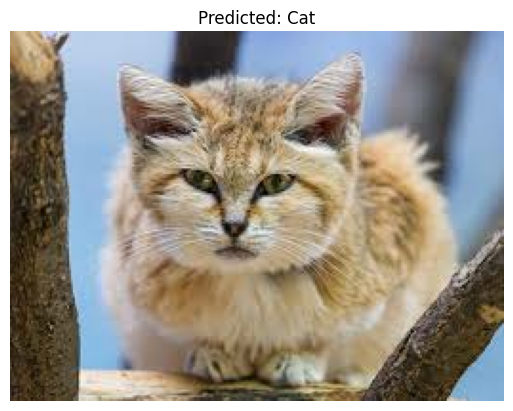

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


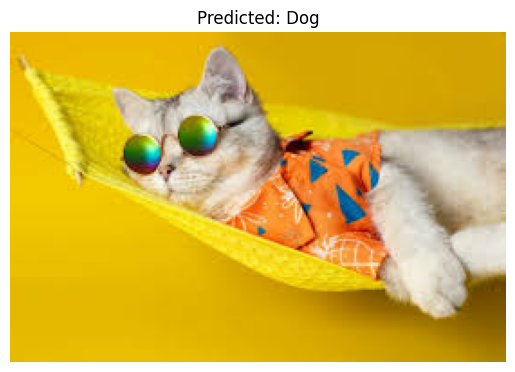

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


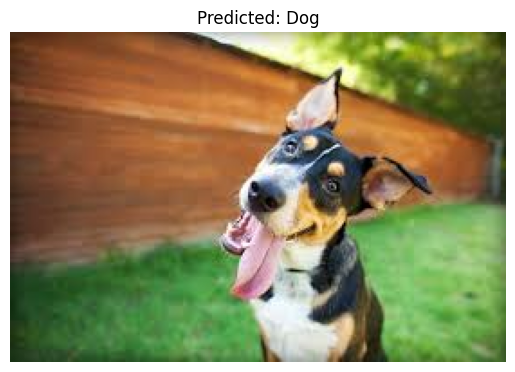

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


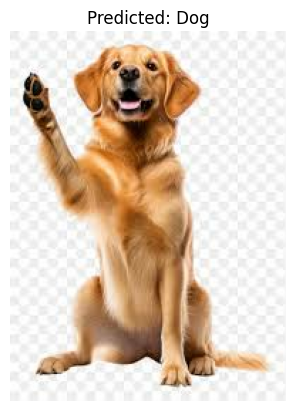

In [62]:
# using model to predict cat or dog

for img_path in image_paths:
    predict_and_display(img_path, model)